In [1]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px

In [3]:
# Read movie data
credits = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv')
movies = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')


### EDA (Exploratory Data Analysis)

In [4]:

# Display the first few rows of the dataset as a table
pd.set_option("display.max_columns", None)  # Display all columns
pd.set_option("display.expand_frame_repr", False)  # Prevent wrapping
pd.set_option("display.max_colwidth", None)  # Display full cell content

movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name"": ""space travel""}, {""id"": 9685, ""name"": ""futuristic""}, {""id"": 9840, ""name"": ""romance""}, {""id"": 9882, ""name"": ""space""}, {""id"": 9951, ""name"": ""alien""}, {""id"": 10148, ""name"": ""tribe""}, {""id"": 10158, ""name"": ""alien planet""}, {""id"": 10987, ""name"": ""cgi""}, {""id"": 11399, ""name"": ""marine""}, {""id"": 13065, ""name"": ""soldier""}, {""id"": 14643, ""name"": ""battle""}, {""id"": 14720, ""name"": ""love affair""}, {""id"": 165431, ""name"": ""anti war""}, {""id"": 193554, ""name"": ""power relations""}, {""id"": 206690, ""name"": ""mind and soul""}, {""id"": 209714, ""name"": ""3d""}]",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporation"", ""id"": 306}, {""name"": ""Dune Entertainment"", ""id"": 444}, {""name"": ""Lightstorm Entertainment"", ""id"": 574}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [5]:

# Display the first few rows of the dataset as a table
pd.set_option("display.max_columns", None)  # Display all columns
pd.set_option("display.expand_frame_repr", False)  # Prevent wrapping
pd.set_option("display.max_colwidth", None)  # Display full cell content

credits.head(1)

movie_id   title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [6]:
# Merge movie data with credits data
movies = movies.merge(credits)

In [7]:
# Identify and remove duplicate columns
movies = movies.loc[:,~movies.columns.duplicated()]

# Now,'movies' DataFrame will contain only unique columns.


In [8]:
# Select relevant columns
movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]

In [9]:
print("First Few Rows of the Movie Dataset:")
print(movies.head(1))

First Few Rows of the Movie Dataset:
   movie_id   title                                                                                                                                                                         overview                                                                                                                                  genres                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [10]:
# Check the shape of the dataset
print("\nShape of the Movie Dataset:")
print(movies.shape)



Shape of the Movie Dataset:
(4809, 7)


### PREPROCESSING

In [11]:
# Define a function to extract names from a JSON-like string
def extract_names(text):
    name_list = []
    for item in ast.literal_eval(text):
        name_list.append(item['name'])
    return name_list

In [12]:
# Drop rows with missing data
movies.dropna(inplace=True)

In [13]:
# Limit the 'cast' to the top 3 actors
movies['cast'] = movies['cast'].apply(lambda x: x[:3])

In [14]:
# Define a function to extract the director from 'crew'
def extract_director(text):
    director_list = []
    for item in ast.literal_eval(text):
        if item['job'] == 'Director':
            director_list.append(item['name'])
    return director_list


In [15]:
# Define a function to collapse spaces in names
def collapse_spaces(name_list):
    cleaned_names = [name.replace(" ", "") for name in name_list]
    return cleaned_names


In [16]:
# Apply the space collapsing function to relevant columns
columns_to_clean = ['cast', 'crew', 'genres', 'keywords']
for column in columns_to_clean:
    movies[column] = movies[column].apply(collapse_spaces)


In [17]:
# Split 'overview' into individual words
movies['overview'] = movies['overview'].apply(lambda x: x.split())

In [18]:
# Combine all text features into a single 'tags' column
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']


In [19]:
# Drop unnecessary columns
movies.drop(columns=['overview', 'genres', 'keywords', 'cast', 'crew'], inplace=True)


In [20]:
# Join all text in 'tags' column into a single string
movies['tags'] = movies['tags'].apply(lambda x: " ".join(x))


In [21]:
movies.head()

movie_id                                     title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### MODELING

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Apply CountVectorizer to create a feature matrix
cv = CountVectorizer(max_features=5000, stop_words='english')
vector = cv.fit_transform(movies['tags']).toarray()


In [23]:
# Calculate cosine similarity between movies
similarity = cosine_similarity(vector)

In [24]:
# Define a function to recommend similar movies
def recommend(movie_title):
    index = movies[movies['title'] == movie_title].index[0]
    distances = sorted(list(enumerate(similarity[index]), reverse=True, key=lambda x: x[1]))
    recommended_movies = [movies.iloc[i[0]].title for i in distances[1:6]]
    return recommended_movies


In [25]:
def recommend(movie_title):
    if movie_title in movies['title'].values:
        index = movies[movies['title'] == movie_title].index[0]
        distances = sorted(enumerate(similarity[index]), key=lambda x: x[1], reverse=True)
        recommended_movies = [movies.iloc[i[0]].title for i in distances[1:6]]
        return recommended_movies
    else:
        return ["Movie not found in the dataset"]

# Example recommendation
recommended_movies = recommend('Avatar')
print("\nRecommended Movies for 'Avatar':")
for movie in recommended_movies:
    print(movie)





Recommended Movies for 'Avatar':
Beowulf
Apollo 18
Tears of the Sun
The American
Aliens vs Predator: Requiem


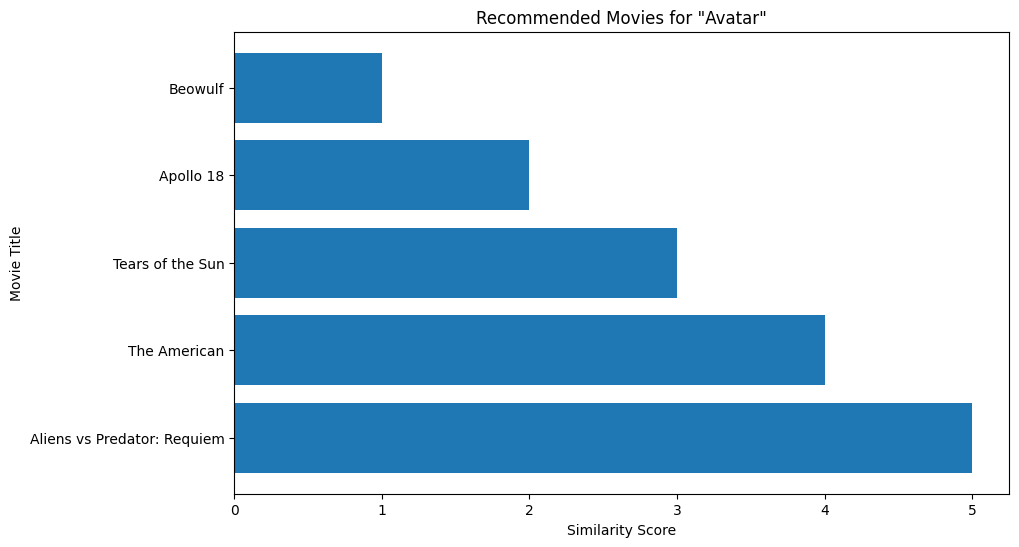

In [26]:
recommended_movies = recommend('Avatar')

# Create a bar chart for recommended movies
plt.figure(figsize=(10, 6))
plt.barh(recommended_movies, range(1, len(recommended_movies) + 1))
plt.gca().invert_yaxis()
plt.title('Recommended Movies for "Avatar"')
plt.xlabel('Similarity Score')
plt.ylabel('Movie Title')
plt.show()
